# Проектная работа. Принятие решений в бизнесе. АБ тест для крупного интернет магазина
Вы — аналитик крупного интернет-магазина. Вашей задачей является приоритизация гипотез по увеличению выручки с использованием фреймворков ICE и RICE, а также анализ результатов A/B-теста

### Цель проекта
Оценить и приоритизировать гипотезы для увеличения выручки интернет-магазина, провести анализ A/B-теста и принять решение по его результатам.

### Ход выполнения проекта
В нашем распоряжении есть 3 датасета: hypothesis.csv, хранящий 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort; orders.csv, хранящий информацию о заказах интернет-магазина, которые попали в АБ тест (с разделением по группам); visitors.csv, хранящий информацию о посетителях сайта, которые попали в АБ тест (с разделением по группам). О качестве данных нет никакой информации. Поэтому прежде чем приступить к анализу, понадобиться обзор данных, чтобы полученные в конечном итоге результаты были достоверны

Поэтому мой проект будет иметь следующий порядок действий:
1. Выгрузка данных
2. Предобработка данных
3. Приоретизация гипотез
4. Анализ AB - теста
5. Общие выводы

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

Выгрузим данные (таким образом, чтобы загрузить можно было даже при отсутствии файла на компьютере):

In [2]:
try:
    hypothesis_df = pd.read_csv('hypothesis.csv')
    orders_df = pd.read_csv('orders.csv')
    visitors_df = pd.read_csv('visitors.csv')
except:
    hypothesis_df = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors_df = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

Проверим, что датафреймы выгрузились успешно:

In [3]:
hypothesis_df.info()
hypothesis_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
orders_df.info()
orders_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors_df.info()
visitors_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Проведем предобработку данных (если она потребуется):

In [6]:
print('Наличие дубликатов: {}'.format(hypothesis_df.duplicated().sum()))
print('-' * 43)
print('Наличие пропусков:')
print(hypothesis_df.isna().sum())
print('-' * 43)
print('Стат.данные датафрейма:')
display(hypothesis_df.describe())

Наличие дубликатов: 0
-------------------------------------------
Наличие пропусков:
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
-------------------------------------------
Стат.данные датафрейма:


,Reach,Impact,Confidence,Efforts
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


Как можно заметить, в таблице с гипотезами нет ни пропусков, ни дубликатов. Все колонки указаны с верным типом данных. Однако для удобства дальнейшего использования приведем названия колонок к нижнему регистру:

In [7]:
hypothesis_df.columns= hypothesis_df.columns.str.lower()
hypothesis_df.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Перейдем к сл.датафрейму:

In [8]:
print('Наличие дубликатов: {}'.format(orders_df.duplicated().sum()))
print('-' * 43)
print('Наличие пропусков:')
print(orders_df.isna().sum())
print('-' * 43)
print('Стат.данные датафрейма:')
display(orders_df.describe())

Наличие дубликатов: 0
-------------------------------------------
Наличие пропусков:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
-------------------------------------------
Стат.данные датафрейма:


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


Как можно заметить, столбец с датой указан с неверным типом, необходимо перевести в тип дата. Также изменим названия колонок transactionId, visitorId в соответствии с правилами

In [9]:
orders_df['date']= pd.to_datetime(orders_df['date'], format='%Y-%m-%d')
orders_df = orders_df.rename(columns = {'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace = False)
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проверим датафрейм на аномалии (юзеры которые могли войти в обе группы):

In [10]:
double_group_users = np.intersect1d(orders_df[orders_df['group'] == 'A']['visitor_id'].unique(), orders_df[orders_df['group'] == 'B']['visitor_id'].unique())
print('Количество пользователей вошедших в обе группы -', len(double_group_users))

Количество пользователей вошедших в обе группы - 58


Исключим таких пользователей из датафрейма

In [11]:
orders_df = orders_df[np.logical_not(orders_df['visitor_id'].isin(double_group_users))]

In [12]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1016 non-null   int64         
 1   visitor_id      1016 non-null   int64         
 2   date            1016 non-null   datetime64[ns]
 3   revenue         1016 non-null   int64         
 4   group           1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Перейдем к таблице с пользователями:

In [13]:
print('Наличие дубликатов: {}'.format(visitors_df.duplicated().sum()))
print('-' * 43)
print('Наличие пропусков:')
print(visitors_df.isna().sum())
print('-' * 43)
print('Стат.данные датафрейма:')
display(visitors_df.describe())

Наличие дубликатов: 0
-------------------------------------------
Наличие пропусков:
date        0
group       0
visitors    0
dtype: int64
-------------------------------------------
Стат.данные датафрейма:


,visitors
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


Приведем колонку date к правильному типу:

In [14]:
visitors_df['date']= pd.to_datetime(visitors_df['date'], format='%Y-%m-%d')
visitors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Теперь все данные проверены, корректны, без дубликатов и пропусков и все в соответствии с правилами

# Промежуточный вывод
В датафреймы 'hypothesis_df', 'orders_df' и 'visitors_df' загружены данные
Предобработка данных показала:
- пропуски в данных отсутствуют
- дубликаты отсутствуют
- Удалены пользователи, которые попали в обе группы
- Названия столбцов приведены к правильному виду
- скорректированы типы данных в колонках date для таблиц orders и visitors

## Часть 1. Приоритизация гипотез
В файле /datasets/hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Задача
- Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
- Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Применим фреймворк ICE для приоритизации гипотез

In [15]:
hypothesis_df['ice'] = round((hypothesis_df['impact'] * hypothesis_df['confidence']) / hypothesis_df['efforts'], 2)
display(hypothesis_df[['hypothesis','ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Применим фреймворк RICE для приоритизации гипотез

In [16]:
hypothesis_df['rice'] = round((hypothesis_df['reach'] * hypothesis_df['impact'] * hypothesis_df['confidence']) / hypothesis_df['efforts'], 2)
display(hypothesis_df[['hypothesis','rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Промежуточный вывод по приоритезации гипотез:
Включение параметра Reach (охват пользователей) в метод RICE изменило приоритетность гипотез по сравнению с методом ICE:
1. Гипотеза о скидке на товар в день рождения, хотя и занимала первое место по методу ICE, теперь имеет более низкий приоритет из-за своего ограниченного охвата пользователей.
2. По методу RICE более высокий приоритет получили гипотезы о добавлении формы подписки на все основные страницы, добавлении блоков рекомендаций товаров и изменении структуры категорий.
3. Позиция гипотез о добавлении баннеров с акциями на главную страницу и об изменении цвета фона осталась неизменной.

Таким образом, учет охвата пользователей в методе RICE привел к изменению приоритетности гипотез и более осмысленному распределению ресурсов для их проверки.

## Часть 2. Анализ A/B-теста
Проанализируйте A/B-тест:
1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
4. Постройте график кумулятивного среднего количества заказов на посетителя по группам. Сделайте выводы и предположения.
5. Постройте график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Сделайте выводы и предположения.
6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
10. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. Сделайте выводы и предположения.
11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
12. Посчитайте статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Сделайте выводы и предположения.
13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
14. Примите решение по результатам теста и объясните его. Варианты решений:
- Остановить тест, зафиксировать победу одной из групп.
- Остановить тест, зафиксировать отсутствие различий между группами.
- Продолжить тест.

График кумулятивной выручки по группам

Создадим DataFrame под названием dates_groups, в котором будут уникальные сочетания значений 'date' и 'group' из таблицы orders. Затем удалим все дубликаты с помощью метода drop_duplicates().

In [17]:
dates_gr = orders_df[['date','group']].drop_duplicates().reset_index(drop = True)
dates_gr.head()

,date,group
0,2019-08-15,B
1,2019-08-15,A
2,2019-08-16,A
3,2019-08-16,B
4,2019-08-01,A


Объявим переменную orders_aggregated, содержащую:
- дату
- группу A/B-теста
- число уникальных заказов в группе теста по указанную дату включительно
- число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно
- суммарную выручку заказов в группе теста по указанную дату включительно

In [18]:
orders_aggregated = dates_gr.apply(lambda x: orders_df[np.logical_and \
   (orders_df['date'] <= x['date'], orders_df['group'] == x['group'])]\
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique','visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1) \
    .sort_values(by=['date','group']).reset_index(drop = True)
orders_aggregated.head()

,date,group,transaction_id,visitor_id,revenue
0,2019-08-01,A,23,19,142779
1,2019-08-01,B,17,17,59758
2,2019-08-02,A,42,36,234381
3,2019-08-02,B,40,39,221801
4,2019-08-03,A,66,60,346854


Объявим переменную visitors_aggregated, содержащую:
- дату
- группу A/B-теста
- количество уникальных посетителей в группе теста по указанную дату включительно

In [19]:
visitors_aggregated = dates_gr.apply(lambda x: visitors_df[np.logical_and\
                    (visitors_df['date'] <= x['date'], visitors_df['group'] == x['group'])]\
                    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                    .sort_values(by=['date','group']).reset_index(drop = True)
visitors_aggregated.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-01,B,713
2,2019-08-02,A,1338
3,2019-08-02,B,1294
4,2019-08-03,A,1845


Создадим переменную cumulative_data, объединив данные из таблиц orders_aggregated и visitors_aggregated по колонкам 'date' и 'group'. Затем присвоим столбцам cumulative_data следующие названия: ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors'].

In [20]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on = ['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Создадим переменные cumulative_revenue_a и cumulative_revenue_b, в которых будем хранить данные о датах, выручке и числе заказов в группах A и B. Затем построим графики кумулятивной выручки по дням для каждой из групп.

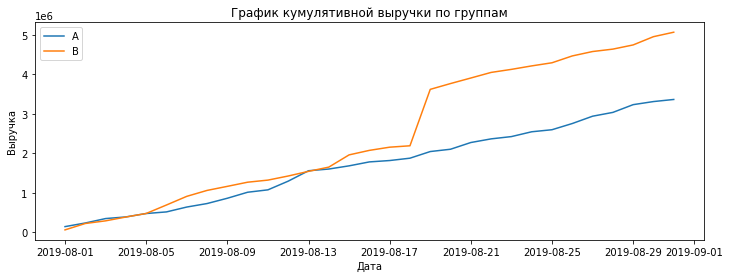

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,4))
# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.title('График кумулятивной выручки по группам', size=12)
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.legend();

#### Вывод
График показывает, что кумулятивная выручка в группе B выше, и изменения, внесенные в группе B, оказались положительными. Поэтому мы решили продолжить исследование. Однако, в группе B наблюдается значительный скачок в районе 2019.08.18 - 2019.08.19, что выглядит как потенциальная аномалия.

График кумулятивного среднего чека по группам

Для создания графика среднего чека по группам мы разделим кумулятивную выручку на кумулятивное количество заказов.

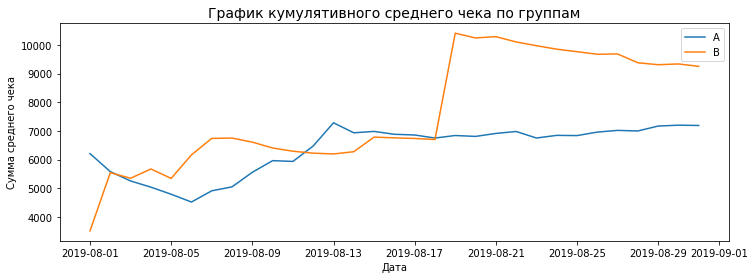

In [22]:
plt.figure(figsize=(12,4))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам', size=14)
plt.xlabel("Дата")
plt.ylabel("Сумма среднего чека")
plt.legend();

#### Вывод
Рост кумулятивного среднего чека в сегменте B также заметен в период с 2019.08.18 по 2019.08.19. Вероятно, прежде чем делать какие-либо выводы на основе этой метрики, необходимо провести дополнительный анализ выбросов, которые могут исказить результаты.

График относительного изменения кумулятивного среднего чека группы B к группе A

В переменной mergе_cum_revenue объединим таблицы cumulative_revenue_a и cumulative_revenue_b

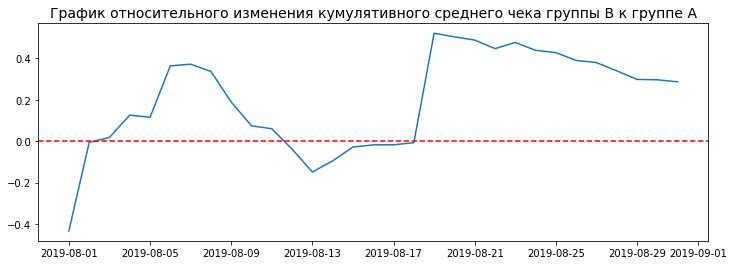

In [23]:
merge_cum_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on = 'date',\
                                          right_on = 'date', how = 'left', suffixes=['_a', '_b'])

plt.figure(figsize=(12,4))
plt.plot(merge_cum_revenue['date'], (merge_cum_revenue['revenue_b'] / merge_cum_revenue['orders_b']) / (merge_cum_revenue['revenue_a'] / merge_cum_revenue['orders_a']) - 1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A', size=14)

plt.axhline(y = 0, color = 'red', linestyle = '--');

#### Вывод
На графике отчетливо прослеживаются значительные колебания относительного изменения кумулятивного среднего чека, которые, по-видимому, связаны с наличием аномальных заказов.

График кумулятивного среднего количества заказов на посетителя по группам

Добавим в датафрейм cumulative_data столбец 'conversion', в котором будет отражено отношение числа заказов к количеству пользователей в указанной группе в указанный день. Затем создадим переменные cumulative_data_a и cumulative_data_b, в которых будут содержаться данные о заказах в сегментах A и B соответственно.

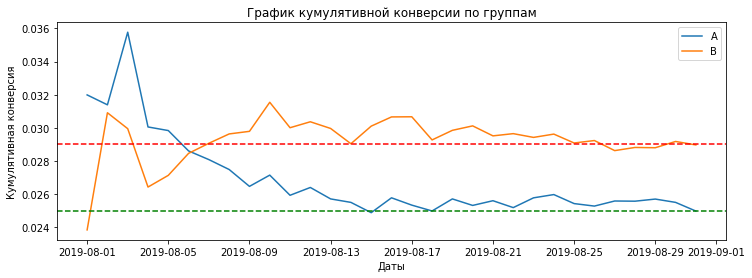

In [24]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

plt.figure(figsize = (12,4))
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label = 'A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label = 'B')

plt.axhline(y = 0.025, color = 'green', linestyle = '--')
plt.axhline(y = 0.029, color = 'red', linestyle = '--')

plt.title('График кумулятивной конверсии по группам', size = 12)
plt.xlabel("Даты")
plt.ylabel("Кумулятивная конверсия")
plt.legend();

#### Вывод
В начале теста конверсия в обеих группах сильно колебалась. Однако со временем мы видим снижение конверсии в группе A, тогда как в группе B конверсия стала выше.

К концу теста колебания конверсии в сегментах составляют примерно: около 0.025 для группы A и около 0.029 для группы B

График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

В merge_cum_conversions объединим таблицы cumulative_data_a и cumulative_data_b

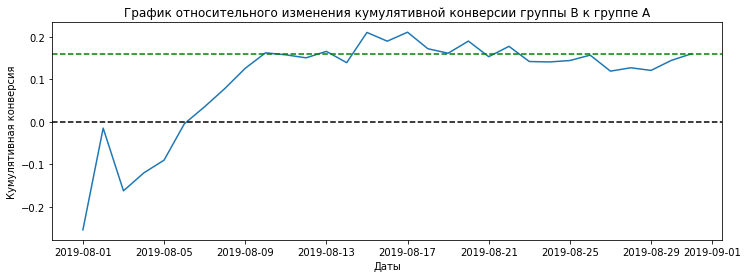

In [25]:
merge_cum_conversions = cumulative_data_a[['date','conversion']] \
.merge(cumulative_data_b[['date','conversion']], left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])

plt.figure(figsize=(12,4))
plt.plot(merge_cum_conversions['date'], merge_cum_conversions['conversionB'] / merge_cum_conversions['conversionA'] - 1, \
         label = "Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A', size = 12)
plt.xlabel("Даты")
plt.ylabel("Кумулятивная конверсия")
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.16, color = 'green', linestyle = '--');

#### Вывод
Конверсия группы B относительно группы A колеблется в районе 0.14, и мы не наблюдаем значительных изменений. Это указывает на то, что конверсия в группе B выше, подтверждая выводы, сделанные на предыдущем графике.

Точечный график количества заказов по пользователям

Произведем расчет количества заказов по пользователям

In [26]:
orders_per_us = orders_df.drop(['group', 'revenue', 'date'], axis = 1) \
  .groupby('visitor_id', as_index = False) \
  .agg({'transaction_id' : pd.Series.nunique})
orders_per_us.columns = ['visitor_id','orders']

print(orders_per_us.sort_values(by = 'orders', ascending = False).head(10))

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


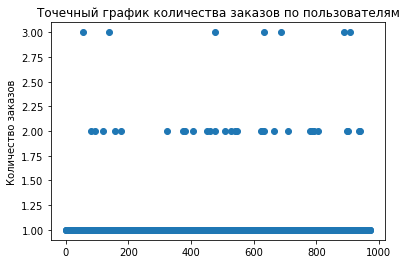

In [27]:
x_values = pd.Series(range(0, len(orders_per_us)))
plt.scatter(x_values, orders_per_us['orders'])
plt.title('Точечный график количества заказов по пользователям', size = 12)
plt.ylabel("Количество заказов");

#### Вывод
Большинство клиентов совершили всего один заказ. Также значительная часть пользователей сделала 2 или 3 заказа. Для определения аномальных значений необходимо рассчитать выборочные перцентили количества заказов на одного пользователя.

Расчет 95-й и 99-й перцентили количества заказов на пользователя

In [28]:
print(np.percentile(orders_per_us['orders'], [95, 99]))

[1. 2.]


#### Вывод
Менее 5% пользователей сделали более одного заказа, а менее 1% пользователей сделали более двух заказов. Пользователей, совершивших более одного заказа, будем считать аномалиями.

Точечный график стоимостей заказов

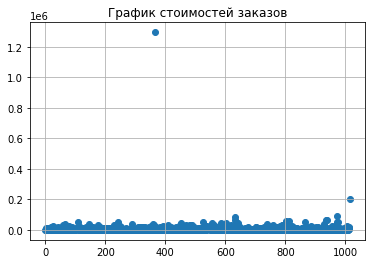

In [29]:
x_values = pd.Series(range(0, len(orders_df['revenue'])))
plt.scatter(x_values, orders_df['revenue'])
plt.title('График стоимостей заказов')
plt.grid()

#### Вывод
На первый взгляд заметна существенная аномалия. Однако, для точного определения аномальных значений стоимости заказа, необходимо вычислить 95-й и 99-й перцентили.

In [30]:
print(np.percentile(orders_df['revenue'], [95, 99]))

[26785. 53904.]


#### Вывод
Менее 5% заказов имеют стоимость выше 26785, а менее 1% - выше 53903. Все заказы, стоимость которых превышает 26785, могут быть считаны аномалиями.

### Статистическая значимость различий

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей

In [31]:
#создаем датафрейм с посетителями по дням в группе А
visitorsADaily_df = visitors_df[visitors_df['group']=='A'][['date', 'visitors']]
visitorsADaily_df.columns = ['date', 'visitorsPerDateA']
visitorsADaily_df.head()

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


In [32]:
# Соберём кумулятивные по дням данные о количестве пользователей в группе A
visitorsACummulative = visitorsADaily_df.apply(lambda x: visitorsADaily_df[visitorsADaily_df['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']
visitorsACummulative.head()

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [33]:
#Сделаем аналогично, но с группой B
visitorsBDaily_df = visitors_df[visitors_df['group']=='B'][['date', 'visitors']]
visitorsBDaily_df.columns = ['date', 'visitorsPerDateB']
visitorsBDaily_df.head()

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [34]:
visitorsBCummulative = visitorsBDaily_df.apply(lambda x: visitorsBDaily_df[visitorsBDaily_df['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']
visitorsBCummulative.head()

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [35]:
#Соберем данные о количестве заказов, суммарной выручке по дням в группе А
ordersADaily = orders_df[orders_df['group']=='A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
ordersADaily.head()

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,23,142779
1,2019-08-02,19,91602
2,2019-08-03,24,112473
3,2019-08-04,11,41176
4,2019-08-05,22,86383


In [36]:
#Соберем данные о суммарном (коммулятивном) количестве заказов, суммарной выручке по дням в группе А
ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']
ordersACummulative.head()

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,23,142779
1,2019-08-02,42,234381
2,2019-08-03,66,346854
3,2019-08-04,77,388030
4,2019-08-05,99,474413


In [37]:
#Соберем данные о количестве заказов, суммарной выручке по дням в группе В
ordersBDaily = orders_df[orders_df['group']=='B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBDaily.head()

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,17,59758
1,2019-08-02,23,162043
2,2019-08-03,14,67049
3,2019-08-04,14,96890
4,2019-08-05,21,89908


In [38]:
#Соберем данные о суммерном (коммулятивном) количестве заказов, суммарной выручке по дням в группе В
ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']
ordersBCummulative.head()

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,17,59758
1,2019-08-02,40,221801
2,2019-08-03,54,288850
3,2019-08-04,68,385740
4,2019-08-05,89,475648


In [39]:
#Объеденим полученные данные в один датафрейм
df = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily_df, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily_df, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
df.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Создадим переменные ordersByUsersA и ordersByUsersB со столбцами, в которых для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов

In [40]:
ordersByUsersA = orders_df[orders_df['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']
ordersByUsersA.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [41]:
ordersByUsersB = orders_df[orders_df['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders']
ordersByUsersB

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1
...,...,...
523,4251115836,1
524,4258103007,1
525,4279090005,1
526,4281247801,1


Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [42]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleA.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

In [43]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
sampleB.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой

In [44]:
ordersByUsersA = orders_df[orders_df['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']
ordersByUsersA.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [45]:
ordersByUsersB = orders_df[orders_df['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders']
ordersByUsersB.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [46]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Воспользуемся критерием Манна-Уитни:

- H0: Конверсия в группе A равна конверсии в группе B
- H1: Конверсия в группе A не равна конверсии в группе B

In [47]:
alpha = 0.05
results = st.mannwhitneyu(sampleA, sampleB)
pvalue = results.pvalue
print('P-value: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")

print("Относительный прирост конверсии группы B {0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

P-value:  0.011018084110014696
Отвергаем H0: разница статистически значима
Относительный прирост конверсии группы B 0.160


#### Вывод о статистической разнице в конверсии по сырым данным: 
Можно увидеть, что p-value равен 0.011, что меньше 0.05. Значит, можно сказать, что существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 16%

Найдём относительные различия в среднем чеке между группами

Воспользуемся критерием Манна-Уитни
- H0: Средний чек A равен среднему чеку группы B
- H1: Средний чек A не равен среднему чеку группы B

In [48]:
alpha = 0.05
results = st.mannwhitneyu(orders_df[orders_df['group'] == 'A']['revenue'], orders_df[orders_df['group'] == 'B']['revenue'])
pvalue = results.pvalue
print('P-value: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")
print('---------------------------------------------')
print("Различие среднего чека между сегментами {0:.3f}".format(orders_df[orders_df['group']=='B']['revenue'].mean()/orders_df[orders_df['group']=='A']['revenue'].mean()-1))

P-value:  0.8294908998149533
Не получилось отвергнуть H0: вывод о различии сделать нельзя
---------------------------------------------
Различие среднего чека между сегментами 0.287


#### Вывод о статистической разнице в среднем чеке по сырым данным:
Можно увидеть, что p-value равен 0.83, что больше 0.05. Это значит что статистически значимых различий в среднем чеке между группами нет. Различие среднего чека между сегментами на данный момент равно 28,7%

#### Гипотезы очищенными данными
Будем считать аномальными пользователями тех, кто сделал 2 заказа и более, или тех, кто совершил заказ на сумму от 26785

In [49]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['user_id'], ordersByUsersB[ordersByUsersB['orders'] > 1]['user_id']], axis = 0)
usersWithExpensiveOrders = orders_df[orders_df['revenue'] > 26785]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
(86,)


Всего 86 аномальных пользователей.

Подготовим выборки количества заказов по пользователям по группам теста, исключив аномальных пользователей

In [50]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

Воспользуемся критерием Манна-Уитни:
- H0: Конверсия в группе A равна конверсии в группе B
- H1: Конверсия в группе A не равна конверсии в группе B

In [51]:
alpha = 0.05
results = st.mannwhitneyu(sampleAFiltered, \
                          sampleBFiltered)
pvalue = results.pvalue
print('P-value: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")
print("----------------------------------------------")
print("Относительный прирост конверсии группы B {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

P-value:  0.01593020716573973
Отвергаем H0: разница статистически значима
----------------------------------------------
Относительный прирост конверсии группы B 0.174


#### Вывод о статистической разнице в конверсии между группами с очищенными данными
Как и в случае с сырыми данными, статистическая значимость достигнута (p-value = 0.16 что меньше 0.05). Значит, можно сказать, что существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 17,4% (очистка данных от аномалий дала прирост в показателе в 8,75% от показателя с сырыми данными)

Подготовим выборки для проверки гипотез по среднему чеку с очищенными группами (создадим датафреймы без аномальных пользователей)

In [52]:
sampleAFiltered_rev = orders_df[np.logical_and(orders_df['group']=='A', np.logical_not(orders_df['visitor_id'].isin(abnormalUsers)))]['revenue']
sampleBFiltered_rev = orders_df[np.logical_and(orders_df['group']=='B', np.logical_not(orders_df['visitor_id'].isin(abnormalUsers)))]['revenue']

Воспользуемся критерием Манна-Уитни
- H0: Средний чек A равен среднему чеку группы B
- H1: Средний чек A не равен среднему чеку группы B

In [53]:
alpha = 0.05
results = st.mannwhitneyu(sampleAFiltered_rev, \
                          sampleBFiltered_rev)
pvalue = results.pvalue
print('P-value: ', pvalue)
if (pvalue < alpha):
    print("Отвергаем H0: разница статистически значима")
else:
    print("Не получилось отвергнуть H0: вывод о различии сделать нельзя")
print('-----------------------------------------------')  
print("Различие среднего чека между сегментами {0:.3f}".format(sampleBFiltered_rev.mean()/sampleAFiltered_rev.mean()-1))

P-value:  0.7271286894009963
Не получилось отвергнуть H0: вывод о различии сделать нельзя
-----------------------------------------------
Различие среднего чека между сегментами -0.034


#### Вывод о статистической разнице в среднем чеке между группами:
Как можно заметить, убрав аномальных пользователей, мы снизили значение p-value на 12% (на данный момент p-value равно 0.73). Однако это не изменило выводов. Статистически значимых различий в среднем чеке между группами  до сих пор нет. Однако разница между группами изменилось с показателя в 28,7% до -3,4% (т.е. если раньше превосходила группа B в среднем чеке, то с очищенными данными эта картина изменилась)

### Вывод по части 2
Выводы из исследования можно сделать следующие:
1. Кумулятивная выручка группы B превосходит группу A.
2. Кумулятивный средний чек в группе A оказывается выше, чем в группе B.
3. Кумулятивная конверсия в группе B превосходит группу A.
4. В случае с сырыми данными, можно сказать, что существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 16%
5. В случае с сырыми данными статистически значимых различий в среднем чеке между группами нет. Различие среднего чека между сегментами на данный момент равно 28,7%
6. Как и в случае с сырыми данными, можно сказать что и с очищенными данными существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 17,4% (очистка данных от аномалий дала прирост в показателе в 8,75% от показателя с сырыми данными)
7. Убрав аномальных пользователей, не изменился вывод о различиях в среднем чеке между группами, его также нет. Однако разница между группами изменилось с показателя в 28,7% до -3,4% (т.е. если раньше превосходила группа B в среднем чеке, то с очищенными данными эта картина изменилась)

В результате можем сделать вывод, что конверсия группы В выше, чем конверсия группы А, в то время как средний чек между группами не отличается. Очистка данных от аномалий не поменяла картину.

Исходя их обнаруженных фактов, тест следует остановить и признать его успешным, потому как при имеющихся данных сегмент B лучше сегмента A.

## Общий вывод
Вы — аналитик крупного интернет-магазина. Вашей задачей является приоритизация гипотез по увеличению выручки с использованием фреймворков ICE и RICE, а также анализ результатов A/B-теста. В нашем распоряжении есть 3 датасета: hypothesis.csv, хранящий 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort; orders.csv, хранящий информацию о заказах интернет-магазина, которые попали в АБ тест (с разделением по группам); visitors.csv, хранящий информацию о посетителях сайта, которые попали в АБ тест (с разделением по группам). О качестве данных нет никакой информации. Поэтому прежде чем приступить к анализу, понадобился обзор данных. После обзора и предобработки: были выгружены три датасета, пропуски в данных отсутствовали, дубликаты отсутствовали, были удалены пользователи, которые попали в обе группы, названия столбцов приведены к правильному виду, скорректированы типы данных в колонках date для таблиц orders и visitors

После приступила к приоритизации гипотез. Включение параметра Reach (охват пользователей) в метод RICE изменило приоритетность гипотез по сравнению с методом ICE:
1. Гипотеза о скидке на товар в день рождения, хотя и занимала первое место по методу ICE, теперь имеет более низкий приоритет из-за своего ограниченного охвата пользователей.
2. По методу RICE более высокий приоритет получили гипотезы о добавлении формы подписки на все основные страницы, добавлении блоков рекомендаций товаров и изменении структуры категорий.
3. Позиция гипотез о добавлении баннеров с акциями на главную страницу и об изменении цвета фона осталась неизменной.

Таким образом, учет охвата пользователей в методе RICE привел к изменению приоритетности гипотез и более осмысленному распределению ресурсов для их проверки.

После приоритизации гипотез, был произведен анализ AB теста, в результате которого было выявлено, что:
1. Кумулятивная выручка группы B превосходит группу A.
2. Кумулятивный средний чек в группе A оказывается выше, чем в группе B.
3. Кумулятивная конверсия в группе B превосходит группу A.
4. В случае с сырыми данными, можно сказать, что существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 16%
5. В случае с сырыми данными статистически значимых различий в среднем чеке между группами нет. Различие среднего чека между сегментами на данный момент равно 28,7%
6. Как и в случае с сырыми данными, можно сказать что и с очищенными данными существует статистически значимые различия между группами в конверсии. Относительный прирост конверсии группы B равен 17,4% (очистка данных от аномалий дала прирост в показателе в 8,75% от показателя с сырыми данными)
7. Убрав аномальных пользователей, не изменился вывод о различиях в среднем чеке между группами, его также нет. Однако разница между группами изменилось с показателя в 28,7% до -3,4% (т.е. если раньше превосходила группа B в среднем чеке, то с очищенными данными эта картина изменилась)

В результате можем сделать вывод, что конверсия группы В выше, чем конверсия группы А, в то время как средний чек между группами не отличается. Очистка данных от аномалий не поменяла картину.

Исходя их обнаруженных фактов, тест следует остановить и признать его успешным, потому как при имеющихся данных сегмент B лучше сегмента A.
Исходя из того что общая комулятивная выручка в группе B выше, то разумно будет остановиться на группе В